### Hand Gastures Improved.

In this notebook we will try to improve our model performance by generating some more images of using data argumentation and get a reasonable accuracy.

Predicting hand gastures based on the dataset found on [Kaggle](https://www.kaggle.com/flintytub49/hand-gestures-black-and-white) which contains images of 5 classes which are black and white.


### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image, image_dataset_from_directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data.
We have 5 classes of images which are:
    
1. Blank
2. First
3. ThumpUp
4. Two
5. Yo

WE have a folder data that contain folders of each class. Basically the file structures looks as follows:
    
```
data
    - Blank
        ..
    - Fist
        ..
    - ThumpUp
        ..
    - Two
        ..
    - Yo
        ..
```

Generating Some more images

In [33]:
DATA_PATH = '/content/drive/MyDrive/Computer Vision/hand-gesture/data'
import os

In [67]:
paths = []
class_names = []
for classes in os.listdir(DATA_PATH):
  class_names.append(classes)
  for path in os.listdir(os.path.join(DATA_PATH, classes))[:1]:
    absolute_path = os.path.join(DATA_PATH, classes, path)
    paths.append(dict({classes: absolute_path}))
paths

[{'ThumbsUp': '/content/drive/MyDrive/Computer Vision/hand-gesture/data/ThumbsUp/1004.jpg'},
 {'Blank': '/content/drive/MyDrive/Computer Vision/hand-gesture/data/Blank/109.jpg'},
 {'Two': '/content/drive/MyDrive/Computer Vision/hand-gesture/data/Two/108.jpg'},
 {'Yo': '/content/drive/MyDrive/Computer Vision/hand-gesture/data/Yo/1073.jpg'},
 {'Fist': '/content/drive/MyDrive/Computer Vision/hand-gesture/data/Fist/247.jpg'},
 {'Five': '/content/drive/MyDrive/Computer Vision/hand-gesture/data/Five/136.jpg'}]

In [79]:
datagen_more_smaples = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

for i, cate in enumerate(paths):
  image = keras.preprocessing.image.load_img(cate[class_names[i]])
  image_array = keras.preprocessing.image.img_to_array(image)
  image_array = image_array.reshape((-1, ) + image_array.shape)
  base_path = os.path.join(DATA_PATH, class_names[i] )
  j = 0
  for batch in datagen_more_smaples.flow(image_array, save_prefix='bee', save_to_dir = base_path, save_format='jpg'):
      j+=1
      if j == 3000:
          break
  print(f"Saved\n Total:\t {j} images for class {class_names[i]}")

Saved
 Total:	 3000 images for class ThumbsUp
Saved
 Total:	 3000 images for class Blank
Saved
 Total:	 3000 images for class Two
Saved
 Total:	 3000 images for class Yo
Saved
 Total:	 3000 images for class Fist
Saved
 Total:	 3000 images for class Five


In [80]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    data_format="channels_last",
    dtype=tf.float32,
    validation_split=0.1,
)

train_ds = datagen.flow_from_directory(
    '/content/drive/MyDrive/Computer Vision/hand-gesture/data',
    target_size=(96, 96),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    interpolation='nearest',
)
validation_ds = datagen.flow_from_directory(
    '/content/drive/MyDrive/Computer Vision/hand-gesture/data',
    target_size=(96, 96),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation',
    interpolation='nearest',
)

Found 16829 images belonging to 6 classes.
Found 1865 images belonging to 6 classes.


### Class Names

In [81]:
train_ds.class_indices

{'Blank': 0, 'Fist': 1, 'Five': 2, 'ThumbsUp': 3, 'Two': 4, 'Yo': 5}

In [83]:
classes = dict([(v, k) for (k, v) in train_ds.class_indices.items() ])

### Displaying some images

In [84]:
for batch in train_ds:
    break

In [85]:
batch[1][1]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

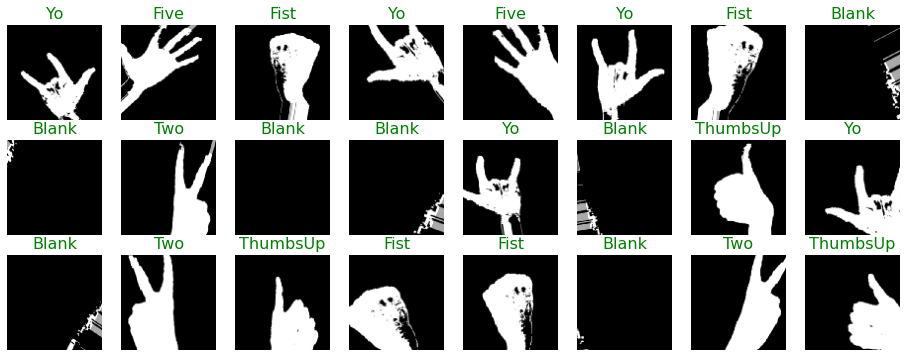

In [86]:
def plot_images(images, labels_true, cols=5):
    rows = 3
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    labels_true = np.argmax(labels_true, axis=1)
    for i, (image, label_true) in enumerate(zip(images, labels_true)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image[:, :, 0], cmap="gray")
        plt.title(classes[label_true], color ='g', fontsize=16 )

plot_images(batch[0][:24], batch[1][:24], cols=8)

In [87]:
batch[0].shape

(32, 96, 96, 1)

### Creating a `NN`
The `NN` achitecture will look as follows:

```
        [ ConvBlock ] -> Conv2D -> BatchNormalization -> ReLU -> MaxPooling2D -> Dropout 
             |
             |
        [Flatten Layer / GlobalMaxPooling2D]
             |
        [Output Block] -> Dense Layers
```

In [88]:
class ConvBlock(keras.layers.Layer):
    def __init__(self, in_features, kernel_size=(3,3), dropout=.5):
        super(ConvBlock, self).__init__()
        self.conv        = keras.layers.Conv2D(in_features, kernel_size=kernel_size)
        self.bn          = keras.layers.BatchNormalization()
        self.relu        = keras.layers.ReLU()
        self.max_pool_2d = keras.layers.MaxPooling2D()
        self.dropout     = keras.layers.Dropout(dropout)
        
    def call(self, in_tensor, training=False):
        x = self.conv(in_tensor)
        x = self.bn(x, training=training)
        x = self.relu(x)
        x = self.max_pool_2d(x)
        return self.dropout(x)
        

In [89]:

model = keras.Sequential([
    keras.layers.Input(shape=(96, 96, 1)),
    ConvBlock(64, kernel_size=(3,3), dropout=.5),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(6, activation='softmax')
], name="hand_gesture_model")

model.summary()

Model: "hand_gesture_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_block_1 (ConvBlock)     (None, 47, 47, 64)        896       
_________________________________________________________________
flatten_2 (Flatten)          (None, 141376)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               72385024  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 3078      
Total params: 72,388,998
Trainable params: 72,388,870
Non-trainable params: 128
_________________________________________________________________


### A Functional Model

In [90]:
input_layer = keras.layers.Input(shape=(96,96,1), name="input_layer")

conv_1 = keras.layers.Conv2D(32, (3, 3), activation="relu")(input_layer)
bn_1 = keras.layers.BatchNormalization()(conv_1)
max_pool_2d1 = keras.layers.MaxPooling2D((2, 2))(conv_1)

conv_2 = keras.layers.Conv2D(32, (3, 3), activation="relu")(max_pool_2d1)
max_pool_2d2 = keras.layers.MaxPooling2D((2, 2))(conv_2)


flatten_layer = keras.layers.Flatten()(max_pool_2d2)
dense_1 = keras.layers.Dense(512, activation="relu")(flatten_layer)
output_layer = keras.layers.Dense(6, activation="softmax")(dense_1)

fn_model = keras.Model(inputs=input_layer, outputs=output_layer, name="fn_model")
fn_model.summary()
fn_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "fn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 15488)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               793

### Trainning `Sequential` model.

In [91]:
model.compile(
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer = keras.optimizers.Adam(),
    metrics = ["acc"]
)

lr_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0, mode='auto'
)

history = model.fit(
    train_ds,
    batch_size=32,
    epochs =20,
    validation_data = validation_ds,
    verbose = 1,
    shuffle=True,
    callbacks = [lr_reduction, early_stopping]
)

Epoch 1/20
526/526 [==============================] - 49s 93ms/step - loss: 2.0634 - acc: 0.7078 - val_loss: 1.4979 - val_acc: 0.5282
Epoch 2/20
526/526 [==============================] - 49s 92ms/step - loss: 0.4034 - acc: 0.8426 - val_loss: 0.9383 - val_acc: 0.8708
Epoch 3/20
526/526 [==============================] - 48s 91ms/step - loss: 0.2910 - acc: 0.8889 - val_loss: 1.0986 - val_acc: 0.8708
Epoch 4/20
526/526 [==============================] - 48s 92ms/step - loss: 0.2325 - acc: 0.9093 - val_loss: 1.1708 - val_acc: 0.8885
Epoch 5/20
526/526 [==============================] - 48s 91ms/step - loss: 0.2200 - acc: 0.9185 - val_loss: 2.1330 - val_acc: 0.8767
Epoch 6/20
526/526 [==============================] - 49s 93ms/step - loss: 0.1990 - acc: 0.9272 - val_loss: 1.7416 - val_acc: 0.8718
Epoch 7/20
526/526 [==============================] - 48s 92ms/step - loss: 0.1935 - acc: 0.9283 - val_loss: 1.5704 - val_acc: 0.8836

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00

### Trainning the `Functional` model.

In [92]:
fn_model.compile(
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer = keras.optimizers.Adam(),
    metrics = ["acc"]
)

lr_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0, mode='auto'
)

fn_model_history = fn_model.fit(
    train_ds,
    batch_size=32,
    epochs =10,
    validation_data = validation_ds,
    verbose = 1,
    shuffle=True,
    callbacks = [lr_reduction, early_stopping]
)

Epoch 1/10
526/526 [==============================] - 47s 88ms/step - loss: 0.1442 - acc: 0.9488 - val_loss: 0.6121 - val_acc: 0.8901
Epoch 2/10
526/526 [==============================] - 46s 87ms/step - loss: 0.0145 - acc: 0.9953 - val_loss: 0.6802 - val_acc: 0.9056
Epoch 3/10
526/526 [==============================] - 46s 87ms/step - loss: 0.0121 - acc: 0.9963 - val_loss: 0.6178 - val_acc: 0.9083
Epoch 4/10
526/526 [==============================] - 45s 86ms/step - loss: 0.0095 - acc: 0.9968 - val_loss: 0.5585 - val_acc: 0.9035
Epoch 5/10
526/526 [==============================] - 46s 87ms/step - loss: 0.0011 - acc: 0.9997 - val_loss: 0.8981 - val_acc: 0.8949
Epoch 6/10
526/526 [==============================] - 46s 87ms/step - loss: 3.8960e-05 - acc: 1.0000 - val_loss: 0.8630 - val_acc: 0.8987

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/10
526/526 [==============================] - 45s 86ms/step - loss: 1.0931e-05 - acc: 1.0000 - val_loss

### Evaluating the model

In [93]:
model.evaluate(validation_ds, batch_size=16, verbose=1 )

59/59 [==============================] - 3s 53ms/step - loss: 1.5704 - acc: 0.8836


[1.57040536403656, 0.8836461305618286]

In [94]:
fn_model.evaluate(validation_ds, batch_size=16, verbose=1 )

59/59 [==============================] - 3s 51ms/step - loss: 0.8924 - acc: 0.8987


[0.8923944234848022, 0.8986595273017883]

### Making Predictions (Inference)

In [95]:
for ds in validation_ds:
  break

In [96]:
predictions = tf.argmax(fn_model(ds[0]), axis=1).numpy()

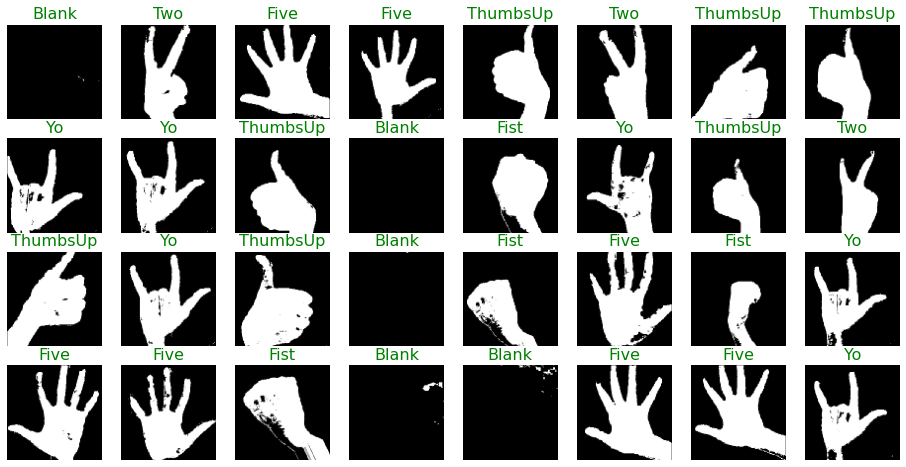

In [99]:
def plot_predictions_images(images_and_classes, labels_true, labels_pred, cols=5):
    rows = 4
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image, label_true, label_pred) in enumerate(zip(images_and_classes, labels_true.astype("int32"), labels_pred)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image[:, :, 0], cmap="gray")
        label_true_index = np.argmax(label_true)
        plt.title(classes[label_pred], color ='g' if label_true_index == label_pred else 'r', fontsize=16 )
plot_predictions_images(ds[0][:32], ds[1][:32], predictions[:32], cols=8)

### Saving the Model

In [98]:
fn_model.save(os.path.join(DATA_PATH, "hand-gestures.h5"))
print("Saved")

Saved
